In [9]:
import torch
import torchvision.datasets as datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [10]:
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: kernel kernelspec migrate run troubleshoot

Jupyter command `jupyter-nbextension` not found.


In [11]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.Compose([transforms.ToTensor()]))
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.Compose([transforms.ToTensor()]))

In [12]:
mnist_testset[0][1]

7

In [5]:
mnist_valset, mnist_testset = torch.utils.data.random_split(mnist_testset, [int(0.9 * len(mnist_testset)), int(0.1 * len(mnist_testset))])

In [6]:
train_dataloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_valset, batch_size=32, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(mnist_testset, batch_size=32, shuffle=False)

In [7]:
print("Training dataset size: ", len(mnist_trainset))
print("Validation dataset size: ", len(mnist_valset))
print("Testing dataset size: ", len(mnist_testset))

Training dataset size:  60000
Validation dataset size:  9000
Testing dataset size:  1000


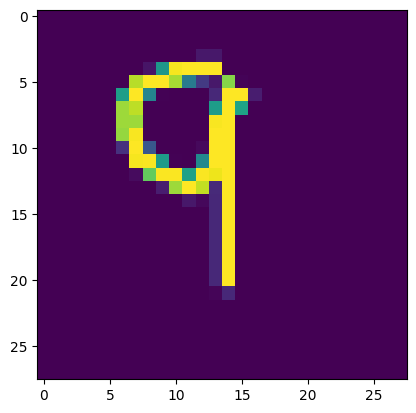

In [22]:
test = torch.tensor([
    [
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0.0631241425871849,
            0.06313084065914154,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0.055798180401325226,
            0.530064046382904,
            0.9889936447143555,
            1,
            1,
            1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0.8968143463134766,
            1,
            1,
            0.8738099932670593,
            0.41889962553977966,
            0.17011891305446625,
            0.06302148103713989,
            0.8216179013252258,
            0.009764580056071281,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0.5610133409500122,
            1,
            0.45643261075019836,
            0.004865708295255899,
            0,
            0,
            0,
            0.11724293231964111,
            1,
            1,
            0.08035118877887726,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0.8571801781654358,
            0.903697669506073,
            0,
            0,
            0,
            0,
            0,
            0.5554149150848389,
            1,
            0.5817001461982727,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0.8571801781654358,
            0.8571804165840149,
            0,
            0,
            0,
            0,
            0,
            0.9924824237823486,
            1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0.8454194068908691,
            0.9947587251663208,
            0,
            0,
            0,
            0,
            0,
            1,
            1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0.14276772737503052,
            1,
            0.27412763237953186,
            0,
            0,
            0,
            0.023885080590844154,
            1,
            1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0.9903051257133484,
            0.9987273216247559,
            0.5523971319198608,
            0.005003653932362795,
            0,
            0.47481152415275574,
            1,
            1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0.03134341537952423,
            0.7684234976768494,
            0.9999999403953552,
            0.9979047775268555,
            0.5763086080551147,
            0.9999884963035583,
            0.9772739410400391,
            1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0.07922755181789398,
            0.8553500175476074,
            1,
            0.913618266582489,
            0.11962414532899857,
            1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0.06325383484363556,
            0.02049039490520954,
            0.11724293231964111,
            1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0.11724292486906052,
            1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0.11724292486906052,
            1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0.11724293231964111,
            1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0.11724293231964111,
            1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0.11724293231964111,
            1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0.11724293231964111,
            1,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0.013745940290391445,
            0.11724323034286499,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ],
        [
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0,
            0
        ]
    ]
])
img = transforms.ToPILImage(mode='L')(test)
plt.imshow(img)
plt.show()


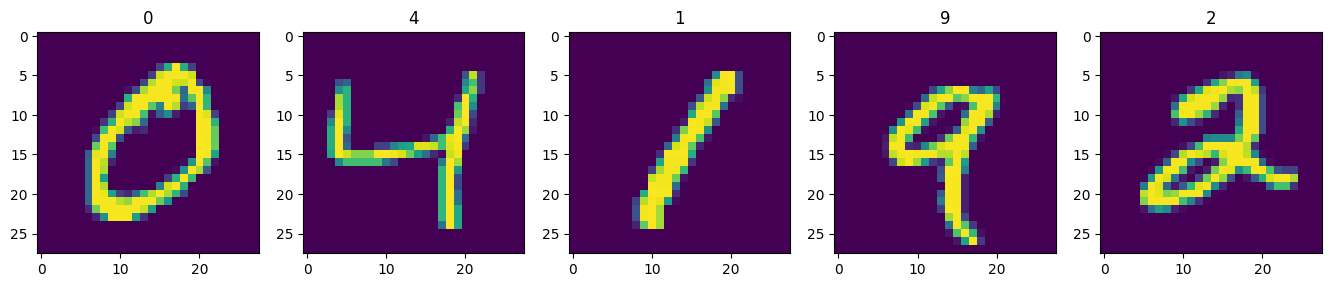

In [13]:
fig=plt.figure(figsize=(20, 10))
for i in range(1, 6):
    img = transforms.ToPILImage(mode='L')(mnist_trainset[i][0])
    fig.add_subplot(1, 6, i)
    plt.title(mnist_trainset[i][1])
    plt.imshow(img)
plt.show()

In [9]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv_1 = torch.nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv_2 = torch.nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.max_pool2d = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.linear_1 = torch.nn.Linear(7 * 7 * 64, 128)
        self.linear_2 = torch.nn.Linear(128, 10)
        self.dropout = torch.nn.Dropout(p=0.5)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.conv_1(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = self.conv_2(x)
        x = self.relu(x)
        x = self.max_pool2d(x)
        x = x.reshape(x.size(0), -1)
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.dropout(x)
        pred = self.linear_2(x)

        return pred

In [10]:
model = Model()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [11]:
if (torch.cuda.is_available()):
    model.cuda()
    print("cuda")

cuda


In [12]:
no_epochs = 10
train_loss = list()
val_loss = list()
best_val_loss = 1
for epoch in range(no_epochs):
    total_train_loss = 0
    total_val_loss = 0

    model.train()
    # training
    for itr, (image, label) in enumerate(train_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        optimizer.zero_grad()

        pred = model(image)

        loss = criterion(pred, label)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    total_train_loss = total_train_loss / (itr + 1)
    train_loss.append(total_train_loss)

    # validation
    model.eval()
    total = 0
    for itr, (image, label) in enumerate(val_dataloader):

        if (torch.cuda.is_available()):
            image = image.cuda()
            label = label.cuda()

        pred = model(image)

        loss = criterion(pred, label)
        total_val_loss += loss.item()

        pred = torch.nn.functional.softmax(pred, dim=1)
        for i, p in enumerate(pred):
            if label[i] == torch.max(p.data, 0)[1]:
                total = total + 1

    accuracy = total / len(mnist_valset)

    total_val_loss = total_val_loss / (itr + 1)
    val_loss.append(total_val_loss)

    print('\nEpoch: {}/{}, Train Loss: {:.8f}, Val Loss: {:.8f}, Val Accuracy: {:.8f}'.format(epoch + 1, no_epochs, total_train_loss, total_val_loss, accuracy))

    if total_val_loss < best_val_loss:
        best_val_loss = total_val_loss
        print("Saving the model state dictionary for Epoch: {} with Validation loss: {:.8f}".format(epoch + 1, total_val_loss))
        torch.save(model.state_dict(), "model.dth")

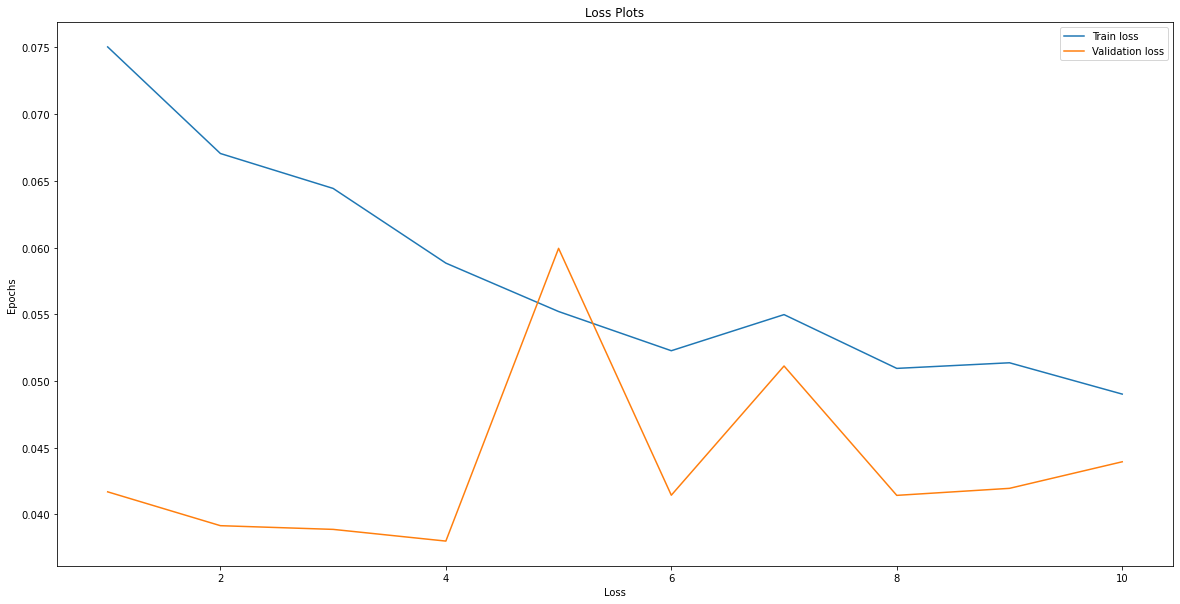

In [ ]:
fig=plt.figure(figsize=(20, 10))
plt.plot(np.arange(1, no_epochs+1), train_loss, label="Train loss")
plt.plot(np.arange(1, no_epochs+1), val_loss, label="Validation loss")
plt.xlabel('Loss')
plt.ylabel('Epochs')
plt.title("Loss Plots")
plt.legend(loc='upper right')
plt.show()

In [ ]:
len(test_dataloader)

32

In [ ]:
model.load_state_dict(torch.load("model.dth"))
model.eval()

results = list()
total = 0
correct = 0
for itr, (image, label) in enumerate(test_dataloader):

    if (torch.cuda.is_available()):
        image = image.cuda()
        label = label.cuda()

    pred = model(image)
    pred = torch.argmax(pred, dim=1)
    for i, p in enumerate(pred):
        if label[i] == p:
            correct += 1
        else:
            results.append((image[i], p))
        total += 1

test_accuracy = correct / total * 100
print('Test accuracy {:.8f}'.format(test_accuracy))

Test accuracy 99.20000000


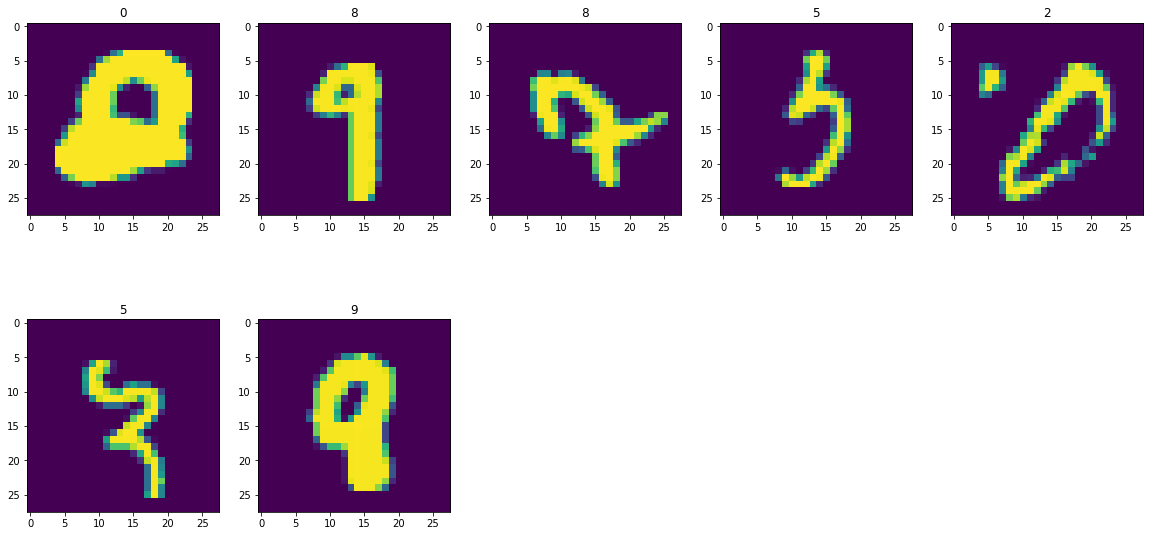

In [ ]:
# visualize results
fig=plt.figure(figsize=(20, 10))
for i in range(1, 8):
    img = transforms.ToPILImage(mode='L')(results[i][0].detach().cpu())
    fig.add_subplot(2, 5, i)
    plt.title(results[i][1].item())
    plt.imshow(img)
plt.show()